<a href="https://colab.research.google.com/github/zetaqubit/udlbook/blob/main/Notebooks/Chap21/21_1_Bias_Mitigation_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 21.1: Bias mitigation**

This notebook investigates a post-processing method for bias mitigation (see figure 21.2 in the book). It based on this [blog](https://www.borealisai.com/research-blogs/tutorial1-bias-and-fairness-ai/) that I wrote for Borealis AI in 2019, which itself was derived from [this blog](https://research.google.com/bigpicture/attacking-discrimination-in-ml/) by Wattenberg, Viégas, and Hardt.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Worked example: loans

Consider the example of an algorithm $c=\text{f}[\mathbf{x},\boldsymbol\phi]$ that predicts credit rating scores $c$ for loan decisions.  There are two pools of loan applicants identified by the variable $p\in\{0,1\}$ that we’ll describe as the blue and yellow populations. We assume that we are given historical data, so we know both the credit rating and whether the applicant actually defaulted on the loan ($y=0$) or
 repaid it ($y=1$).

We can now think of four groups of data corresponding to (i) the blue and yellow populations and (ii) whether they did or did not repay the loan. For each of these four groups we have a distribution of credit ratings (figure 1). In an ideal world, the two distributions for the yellow population would be exactly the same as those for the blue population. However, as figure 1 shows, this is clearly not the case here.

In [2]:
# Class that can describe interesting curve shapes based on the input parameters
# Details don't matter
class FreqCurve:
  def __init__(self, weight, mean1, mean2, sigma1, sigma2, prop):
    self.mean1 = mean1
    self.mean2 = mean2
    self.sigma1 = sigma1
    self.sigma2 = sigma2
    self.prop = prop
    self.weight = weight

  def freq(self, x):
    return self.weight * self.prop * np.exp(-0.5 * (x-self.mean1) * (x-self.mean1) / (self.sigma1 * self.sigma1)) \
                * 1.0 / np.sqrt(2*np.pi*self.sigma1*self.sigma1) \
          + self.weight * (1-self.prop) * np.exp(-0.5 * (x-self.mean2) * (x-self.mean2) / (self.sigma2 * self.sigma2)) \
                * 1.0 / np.sqrt(2*np.pi*self.sigma2*self.sigma2)


In [3]:
credit_scores = np.arange(-4,4,0.01)
freq_y0_p0 = FreqCurve(800, -1.5, -2.5, 0.8, 0.6, 0.6).freq(credit_scores)
freq_y1_p0 = FreqCurve(500, 0.1, 0.7, 1.5, 0.8, 0.4 ).freq(credit_scores)
freq_y0_p1 = FreqCurve(400, 0.2, -0.1, 0.8, 0.6, 0.3).freq(credit_scores)
freq_y1_p1 = FreqCurve(650, 0.6, 1.6, 1.2, 0.7, 0.6 ).freq(credit_scores)


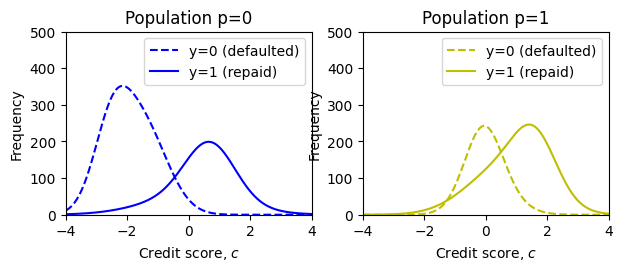

In [4]:

fig = plt.figure
ax = plt.subplot(2,2,1)
plt.tight_layout()
ax.plot(credit_scores, freq_y0_p0, 'b--', label='y=0 (defaulted)')
ax.plot(credit_scores, freq_y1_p0, 'b-', label='y=1 (repaid)')
ax.set_xlim(-4,4)
ax.set_ylim(0,500)
ax.set_xlabel('Credit score, $c$')
ax.set_ylabel('Frequency')
ax.set_title('Population p=0')
ax.legend()

ax = plt.subplot(2,2,2)
plt.tight_layout()
ax.plot(credit_scores, freq_y0_p1, 'y--', label='y=0 (defaulted)')
ax.plot(credit_scores, freq_y1_p1, 'y-', label='y=1 (repaid)')
ax.set_xlim(-4,4)
ax.set_ylim(0,500)
ax.set_xlabel('Credit score, $c$')
ax.set_ylabel('Frequency')
ax.set_title('Population p=1')
ax.legend()

plt.show()

Why might the distributions for blue and yellow populations be different? It could be that the behaviour of the populations is identical, but the credit rating algorithm is biased; it may favor one population over another or simply be more noisy for one group. Alternatively, it could be that that the populations genuinely behave differently. In practice, the differences in blue and yellow distributions are probably attributable to a combination of these factors.

Let’s assume that we can’t retrain the credit score prediction algorithm; our job is to adjudicate whether each individual is refused the loan ($\hat{y}=0$)
 or granted it ($\hat{y}=1$). Since we only have the credit score
 to go on, the best we can do is to assign different thresholds $\tau_{1}$
 and $\tau_{2}$
 for the blue and yellow populations so that the loan is granted if the credit score $c$ generated by the model exceeds $\tau_0$ for the blue population and $\tau_1$ for the yellow population.

Now let's investiate how to set these thresholds to fulfil different criteria.

# Blindness to protected attribute

We'll first do the simplest possible thing.  We'll choose the same threshold for both blue and yellow populations so that $\tau_0$ = $\tau_1$.  Basically, we'll ignore what we know about the group membership.  Let's see what the ramifications of that.

In [5]:
# Set the thresholds
tau0 = tau1 = 0.0

In [6]:
def compute_probability_get_loan(credit_scores, frequencies, threshold):
  # TODO - Write this function
  # Return the probability that someone from this group loan based on the frequencies of each
  # credit score for this group
  # Replace this line:
  prob = frequencies[credit_scores >= threshold].sum() / frequencies.sum()
  return prob

First let's see what the overall probability of getting the loan is for the yellow and blue populations.

In [7]:
pr_get_loan_p0 = compute_probability_get_loan(credit_scores, freq_y0_p0+freq_y1_p0, tau0)
pr_get_loan_p1 = compute_probability_get_loan(credit_scores, freq_y0_p1+freq_y1_p1, tau1)
print("Probability blue group gets loan = %3.3f"%(pr_get_loan_p0))
print("Probability yellow group gets loan = %3.3f"%(pr_get_loan_p1))

Probability blue group gets loan = 0.278
Probability yellow group gets loan = 0.684


Now let's plot a receiver operating characteristic (ROC) curve.  This shows the rate of true positives $Pr(\hat{y}=1|y=1)$ (people who got loan and paid it back) and false alarms $Pr(\hat{y}=1|y=0)$ (people who got the loan but didn't pay it back) for all possible thresholds.

In [40]:
def plot_roc(credit_scores, freq_y0_p0, freq_y1_p0, freq_y0_p1, freq_y1_p1, tau0, tau1):
  true_positives_p0 = np.zeros_like(credit_scores)
  false_alarms_p0 = np.zeros_like(credit_scores)
  true_positives_p1 = np.zeros_like(credit_scores)
  false_alarms_p1 = np.zeros_like(credit_scores)
  for i in range(len(credit_scores)):
    true_positives_p0[i] = compute_probability_get_loan(credit_scores, freq_y1_p0, credit_scores[i])
    true_positives_p1[i] = compute_probability_get_loan(credit_scores, freq_y1_p1, credit_scores[i])
    false_alarms_p0[i] = compute_probability_get_loan(credit_scores, freq_y0_p0, credit_scores[i])
    false_alarms_p1[i] = compute_probability_get_loan(credit_scores, freq_y0_p1, credit_scores[i])

  true_positives_p0_tau0 = compute_probability_get_loan(credit_scores, freq_y1_p0, tau0)
  true_positives_p1_tau1 = compute_probability_get_loan(credit_scores, freq_y1_p1, tau1)
  false_alarms_p0_tau0 = compute_probability_get_loan(credit_scores, freq_y0_p0, tau0)
  false_alarms_p1_tau1 = compute_probability_get_loan(credit_scores, freq_y0_p1, tau1)
  print(f'blue tpr: {true_positives_p0_tau0:.2f}, fpr: {false_alarms_p0_tau0:.2f}')
  print(f'yellow tpr: {true_positives_p1_tau1:.2f}, fpr: {false_alarms_p1_tau1:.2f}')

  fig, ax = plt.subplots()
  ax.plot(false_alarms_p0, true_positives_p0, 'b-')
  ax.plot(false_alarms_p1, true_positives_p1, 'y-')
  ax.plot(false_alarms_p0_tau0, true_positives_p0_tau0,'bo')
  ax.plot(false_alarms_p1_tau1, true_positives_p1_tau1,'yo')
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.set_xlabel('False alarms $Pr(\hat{y}=1|y=0)$')
  ax.set_ylabel('True positives $Pr(\hat{y}=1|y=1)$')
  ax.set_aspect('equal')

  plt.show()

blue tpr: 0.90, fpr: 0.16
yellow tpr: 0.94, fpr: 0.93


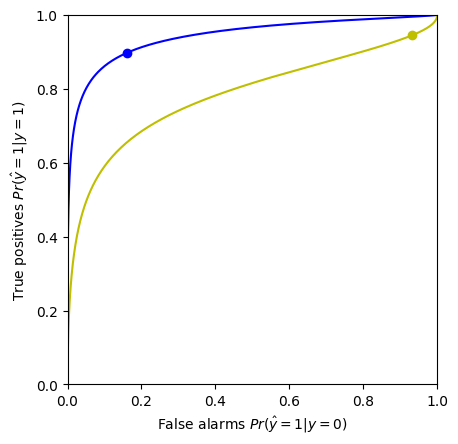

In [41]:
plot_roc(credit_scores, freq_y0_p0, freq_y1_p0, freq_y0_p1, freq_y1_p1, tau0, tau1)

On this plot, the true positive and false alarm rate for the particular thresholds ($\tau_0=\tau_{1}=0$) that we chose are indicated by the circles.

This criterion is clearly not great.  The blue and yellow groups get given loans at different rates overall, and (for this threshold), the false alarms and true positives are also different, so it's not even fair when we consider whether the loans really were paid back.  

TODO -- investigate setting a different threshold $\tau_{0}=\tau_{1}$.  
* Is it possible to make the overall rates that loans are given the same?
  *  A: yes, but only at extreme rates of 0 (everyone rejected) or 1 (everyone accepted)
* Is it possible to make the false alarm rates the same?
  * A: yes, but only at extreme values of 0 or 1
* Is it possible to make the true positive rates the same?
  * A: yes, but only at extreme values of 0 or 1

Probability blue group gets loan = 0.637
Probability yellow group gets loan = 0.990
blue tpr: 0.96, fpr: 0.44
yellow tpr: 0.99, fpr: 1.00


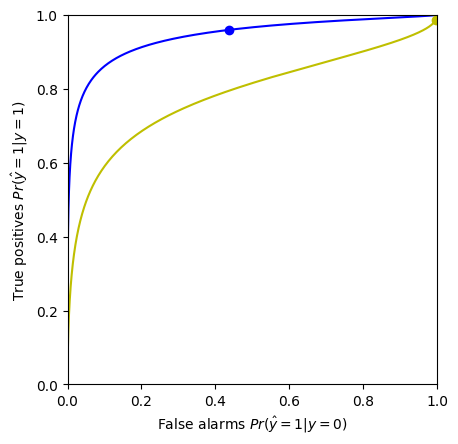

In [44]:
tau0 = tau1 = -1.8

pr_get_loan_p0 = compute_probability_get_loan(credit_scores, freq_y0_p0+freq_y1_p0, tau0)
pr_get_loan_p1 = compute_probability_get_loan(credit_scores, freq_y0_p1+freq_y1_p1, tau1)
print("Probability blue group gets loan = %3.3f"%(pr_get_loan_p0))
print("Probability yellow group gets loan = %3.3f"%(pr_get_loan_p1))
plot_roc(credit_scores, freq_y0_p0, freq_y1_p0, freq_y0_p1, freq_y1_p1, tau0, tau1)

# Equality of odds

This definition of fairness proposes that the false positive and true positive rates should be the same for both populations. This also sounds reasonable, but the ROC curve shows that it is not possible for this example. There is no combination of thresholds that can achieve this because the ROC curves do not intersect. Even if they did, we would be stuck giving loans based on the particular false positive and true positive rates at the intersection which might not be desirable.

Demographic parity

The thresholds can be chosen so that the same proportion of each group are classified as $\hat{y}=1$ and given loans. We make an equal number of loans to each group despite the different tendencies of each to repay. This has the disadvantage that the true positive and false positive rates might be completely different in different populations. From the perspective of the lender, it is desirable to give loans in proportion to people’s ability to pay them back. From the perspective of an individual in a more reliable group, it may seem unfair that the other group gets offered the same number of loans despite the fact they are less reliable.

In [76]:
# TO DO -- try to change the two thresholds so the overall probability of getting the loan is 0.6 for each group
# Change the values in these lines
tau0 = -1.661
tau1 = 0.24



# Compute overall probability of getting loan
pr_get_loan_p0 = compute_probability_get_loan(credit_scores, freq_y0_p0+freq_y1_p0, tau0)
pr_get_loan_p1 = compute_probability_get_loan(credit_scores, freq_y0_p1+freq_y1_p1, tau1)
print("Probability blue group gets loan = %3.3f"%(pr_get_loan_p0))
print("Probability yellow group gets loan = %3.3f"%(pr_get_loan_p1))

Probability blue group gets loan = 0.602
Probability yellow group gets loan = 0.600


This is good, because now both groups get roughly the same amount of loans.  But hold on... let's look at the ROC curve:

blue tpr: 0.95, fpr: 0.38
yellow tpr: 0.76, fpr: 0.34


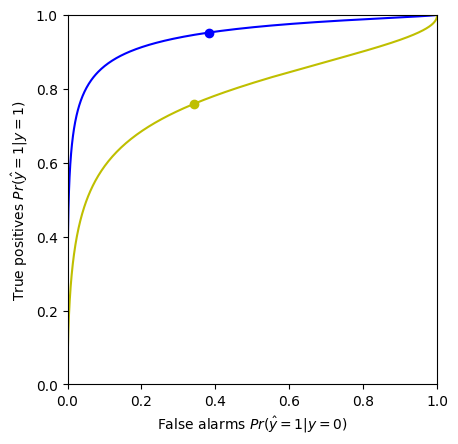

In [77]:
plot_roc(credit_scores, freq_y0_p0, freq_y1_p0, freq_y0_p1, freq_y1_p1, tau0, tau1)

The blue dot is waaay above the yellow dot. The proportion of people who are given a load and do pay it back from the blue population is much higher than that from the yellow population.  From another perspective, that's unfair... it seems like the yellow population are 'allowed' to default more often than the blue. This leads to another possibility.

# Equal opportunity:

The thresholds are chosen so that so that the true positive rate is is the same for both population. Of the people who pay back the loan, the same proportion are offered credit in each group. In terms of the two ROC curves, it means choosing thresholds so that the vertical position on each curve is the same without regard for the horizontal position.

blue tpr: 0.80, fpr: 0.05
yellow tpr: 0.80, fpr: 0.45


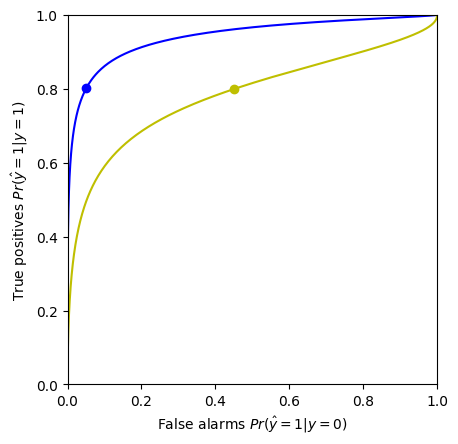

In [88]:
# TO DO -- try to change the two thresholds so the true positive are 0.8 for each group
# Change the values in these lines so that both points on the curves have a height of 0.8
tau0 = -0.4
tau1 = 0.05


plot_roc(credit_scores, freq_y0_p0, freq_y1_p0, freq_y0_p1, freq_y1_p1, tau0, tau1)

This seems fair -- people who are given loans default at the same rate (20%) for both groups.  But hold on... let's look at the overall loan rate between the two populations:

In [89]:
# Compute overall probability of getting loan
pr_get_loan_p0 = compute_probability_get_loan(credit_scores, freq_y0_p0+freq_y1_p0, tau0)
pr_get_loan_p1 = compute_probability_get_loan(credit_scores, freq_y0_p1+freq_y1_p1, tau1)
print("Probability blue group gets loan = %3.3f"%(pr_get_loan_p0))
print("Probability yellow group gets loan = %3.3f"%(pr_get_loan_p1))

Probability blue group gets loan = 0.339
Probability yellow group gets loan = 0.666


The conclusion from all this is that (i) definitions of fairness are quite subtle and (ii) it's not possible to satisfy them all simultaneously.